## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max,building_id
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4,1
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6,1
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5,1
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6,1
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2,1


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 35), (10847,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 35), (8696,), (1087, 24, 35), (1087,), (1064, 24, 35), (1064,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

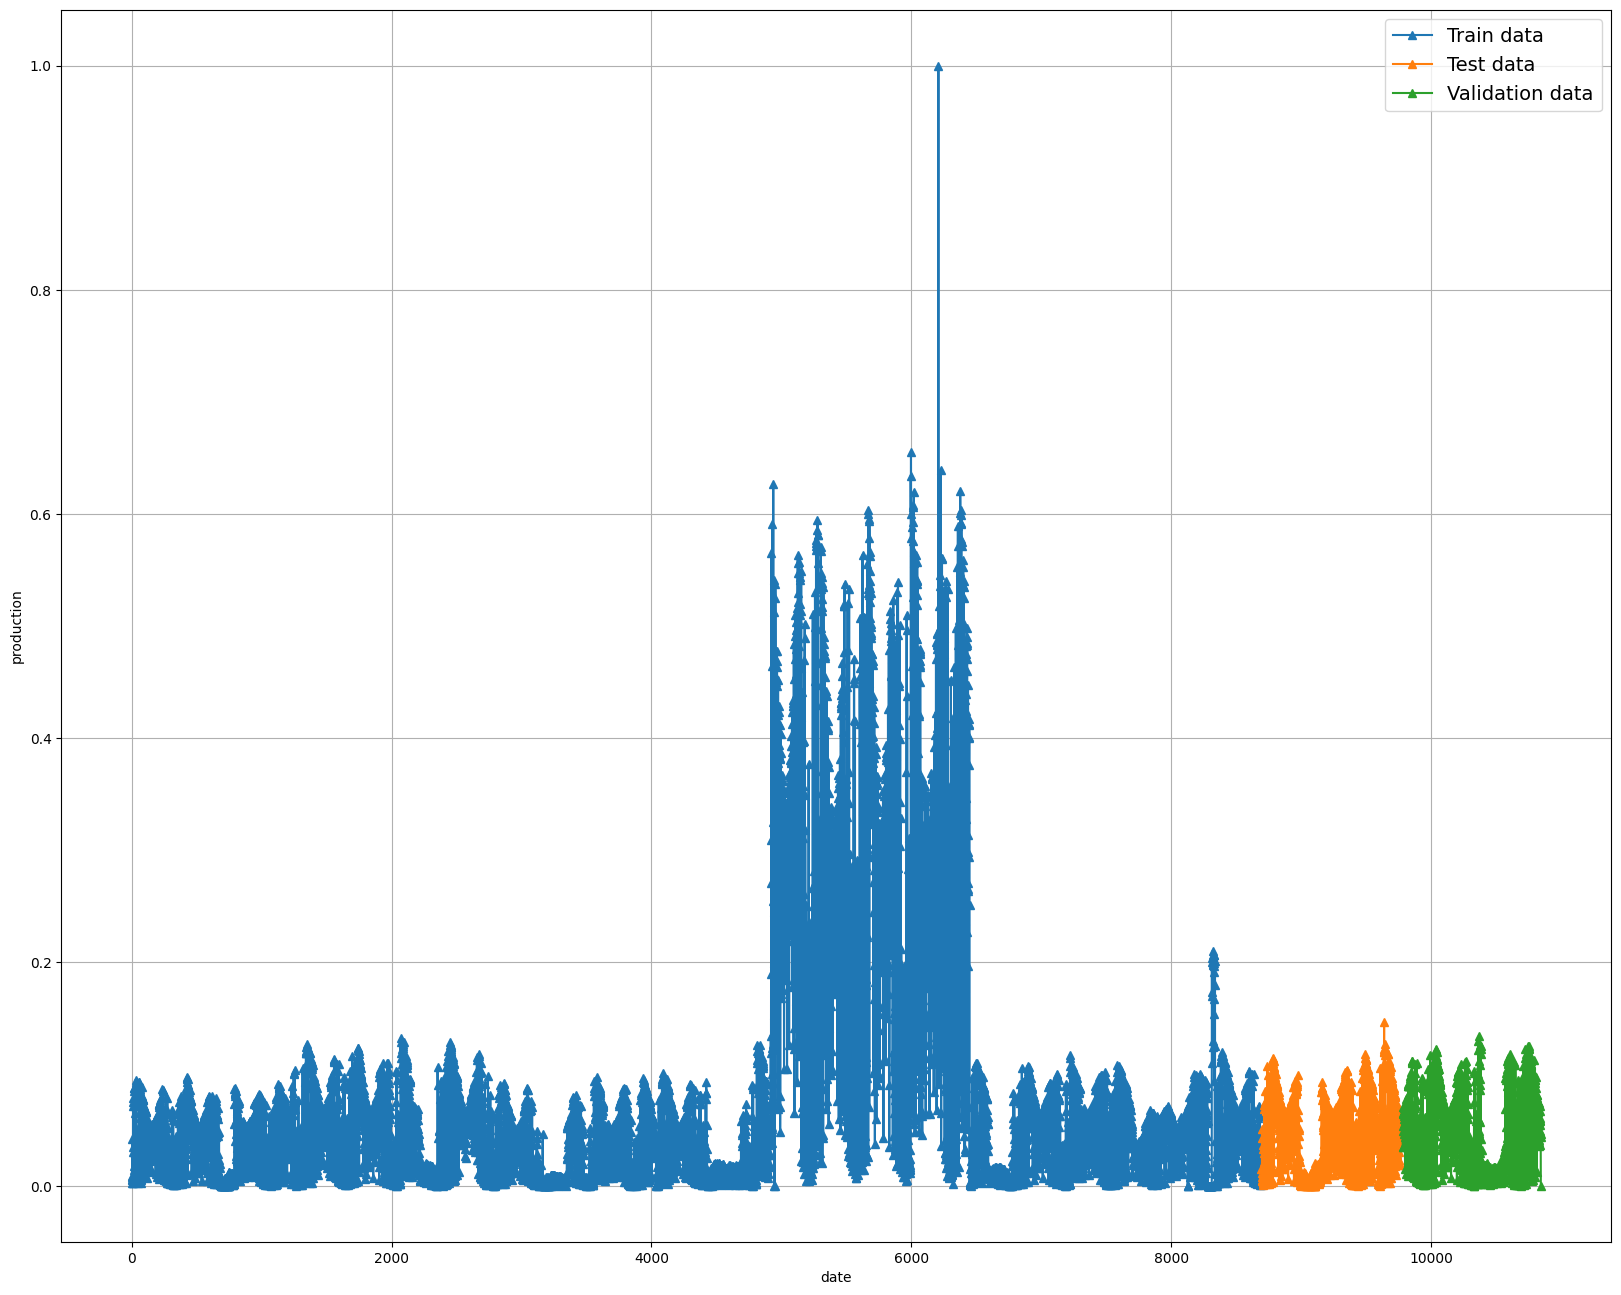

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 35) -> (8696, 24, 1, 35)


In [17]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=42, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=31, kernel_size=(1,),
               activation='relu', return_sequences=False),
    Flatten(),
    Dense(units=85, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003375755523522821))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 42)           │          13,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 31)               │           9,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 31)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 85)                  │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              86 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,086 (97.99 KB)

 Trainable params: 25,086 (97.99 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 15:25:17] [setup] RAM Tracking...
[codecarbon INFO @ 15:25:17] [setup] CPU Tracking...
[codecarbon WARNING @ 15:25:17] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 15:25:19] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 15:25:19] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 15:25:19] [setup] GPU Tracking...
[codecarbon INFO @ 15:25:19] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:25:19] >>> Tracker's metadata:
[codecarbon INFO @ 15:25:19]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 15:25:19]   Python version: 3.12.3
[codecarbon INFO @ 15:25:19]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 15:25:19]   Available RAM : 15.288 GB
[codecarbon INFO @ 15:25:19]   CPU count: 16
[codecarbon INFO @ 15:

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0582 - val_loss: 0.0423
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0438 - val_loss: 0.0312
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0406 - val_loss: 0.0295
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0397 - val_loss: 0.0298
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0393 - val_loss: 0.0292
Epoch 6/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0387

[codecarbon INFO @ 15:25:29] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:25:29] Energy consumed for all CPUs : 0.000119 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0387

[codecarbon INFO @ 15:25:29] Energy consumed for all GPUs : 0.000016 kWh. Total GPU Power : 5.713557471756739 W
[codecarbon INFO @ 15:25:29] 0.000151 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0388 - val_loss: 0.0288
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0384 - val_loss: 0.0288
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0381 - val_loss: 0.0284
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0378 - val_loss: 0.0282
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0376 - val_loss: 0.0284
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0374 - val_loss: 0.0277
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0372 - val_loss: 0.0275
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0370 - val_loss: 0.0276
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0367 - val_loss: 0.0277
Epoch 15/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0364 - val_loss: 0.0277
Epoch 16/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0362 - val_loss: 0.0276
Epoch 17/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss

[codecarbon INFO @ 15:25:39] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:25:39] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:39] Energy consumed for all GPUs : 0.000028 kWh. Total GPU Power : 4.207724369527852 W
[codecarbon INFO @ 15:25:39] 0.000296 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0361 - val_loss: 0.0272
Epoch 18/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0360 - val_loss: 0.0274
Epoch 19/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0356 - val_loss: 0.0276
Epoch 20/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0356 - val_loss: 0.0265
Epoch 21/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0355 - val_loss: 0.0262
Epoch 22/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0353 - val_loss: 0.0261
Epoch 23/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0351 - val_loss: 0.0259
Epoch 24/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0349 - val_loss: 0.0256
Epoch 25/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0350 - val_loss: 0.0253
Epoch 26/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0348 - val_loss: 0.0254
Epoch 27/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0342

[codecarbon INFO @ 15:25:49] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0344

[codecarbon INFO @ 15:25:49] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:49] Energy consumed for all GPUs : 0.000040 kWh. Total GPU Power : 4.4799018381914575 W
[codecarbon INFO @ 15:25:49] 0.000442 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0344 - val_loss: 0.0252
Epoch 28/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0343 - val_loss: 0.0250
Epoch 29/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0342 - val_loss: 0.0249
Epoch 30/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0341 - val_loss: 0.0249
Epoch 31/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0341 - val_loss: 0.0248
Epoch 32/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0339 - val_loss: 0.0247
Epoch 33/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0337 - val_loss: 0.0247
Epoch 34/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0336 - val_loss: 0.0250
Epoch 35/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0334 - val_loss: 0.0252
Epoch 36/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0333 - val_loss: 0.0275
Epoch 37/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0336

[codecarbon INFO @ 15:25:59] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.732982158660889 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0336

[codecarbon INFO @ 15:25:59] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:59] Energy consumed for all GPUs : 0.000051 kWh. Total GPU Power : 3.954444785923993 W
[codecarbon INFO @ 15:25:59] 0.000587 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0336 - val_loss: 0.0259
Epoch 38/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0334 - val_loss: 0.0249
Epoch 39/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0332 - val_loss: 0.0248
Epoch 40/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0329 - val_loss: 0.0250
Epoch 41/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0328 - val_loss: 0.0252
Epoch 42/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0330 - val_loss: 0.0245
Epoch 43/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0328 - val_loss: 0.0241
Epoch 44/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0327 - val_loss: 0.0240
Epoch 45/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0325 - val_loss: 0.0249
Epoch 46/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0325 - val_loss: 0.0256
Epoch 47/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0325 - val_loss: 0.0259
Epoch 48/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - l

[codecarbon INFO @ 15:26:09] Energy consumed for RAM : 0.000079 kWh. RAM Power : 5.732982158660889 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0327

[codecarbon INFO @ 15:26:09] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:09] Energy consumed for all GPUs : 0.000066 kWh. Total GPU Power : 5.189572063778913 W
[codecarbon INFO @ 15:26:09] 0.000736 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0327 - val_loss: 0.0242
Epoch 49/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0326 - val_loss: 0.0234
Epoch 50/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0326 - val_loss: 0.0237
Epoch 51/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0321 - val_loss: 0.0241
Epoch 52/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0319 - val_loss: 0.0247
Epoch 53/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0320 - val_loss: 0.0246
Epoch 54/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0319 - val_loss: 0.0249
Epoch 55/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0319 - val_loss: 0.0238
Epoch 56/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0317 - val_loss: 0.0241
Epoch 57/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0315 - val_loss: 0.0237
Epoch 58/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0317 - val_loss: 0.0242
Epoch 59/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - l

[codecarbon INFO @ 15:26:19] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:26:19] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0313

[codecarbon INFO @ 15:26:19] Energy consumed for all GPUs : 0.000076 kWh. Total GPU Power : 3.696820163836762 W
[codecarbon INFO @ 15:26:19] 0.000880 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0316 - val_loss: 0.0231
Epoch 60/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0315 - val_loss: 0.0238
Epoch 61/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0315 - val_loss: 0.0229
Epoch 62/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0315 - val_loss: 0.0240
Epoch 63/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0314 - val_loss: 0.0245
Epoch 64/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0314 - val_loss: 0.0237
Epoch 65/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0314 - val_loss: 0.0246
Epoch 66/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0313 - val_loss: 0.0249
Epoch 67/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0315 - val_loss: 0.0253
Epoch 68/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0313 - val_loss: 0.0241
Epoch 69/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0312 - val_loss: 0.0256
Epoch 70/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - l

[codecarbon INFO @ 15:26:29] Energy consumed for RAM : 0.000111 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:26:29] Energy consumed for all CPUs : 0.000827 kWh. Total CPU Power : 42.5 W


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0310

[codecarbon INFO @ 15:26:29] Energy consumed for all GPUs : 0.000097 kWh. Total GPU Power : 7.452901955338403 W
[codecarbon INFO @ 15:26:29] 0.001035 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0313 - val_loss: 0.0264
Epoch 71/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0316 - val_loss: 0.0250
Epoch 72/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0320 - val_loss: 0.0221
Epoch 73/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0315 - val_loss: 0.0226
Epoch 74/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0310 - val_loss: 0.0225
Epoch 75/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0313 - val_loss: 0.0224
Epoch 76/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0311 - val_loss: 0.0223
Epoch 77/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0311 - val_loss: 0.0223
Epoch 78/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0312 - val_loss: 0.0220
Epoch 79/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0312 - val_loss: 0.0222
Epoch 80/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0308 - val_loss: 0.0222
Epoch 81/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - l

[codecarbon INFO @ 15:26:39] Energy consumed for RAM : 0.000127 kWh. RAM Power : 5.732982158660889 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0308

[codecarbon INFO @ 15:26:39] Energy consumed for all CPUs : 0.000945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:39] Energy consumed for all GPUs : 0.000105 kWh. Total GPU Power : 2.9494021057736903 W
[codecarbon INFO @ 15:26:39] 0.001177 kWh of electricity used since the beginning.


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0309

[codecarbon INFO @ 15:26:39] 0.000294 g.CO2eq/s mean an estimation of 9.266195662557713 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0309 - val_loss: 0.0223
Epoch 82/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0308 - val_loss: 0.0225
Epoch 83/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0308 - val_loss: 0.0223
Epoch 84/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0307 - val_loss: 0.0222
Epoch 85/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0306 - val_loss: 0.0225
Epoch 86/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0305 - val_loss: 0.0231
Epoch 87/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0304 - val_loss: 0.0235
Epoch 88/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0306 - val_loss: 0.0233
Epoch 89/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0305 - val_loss: 0.0240
Epoch 90/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0304 - val_loss: 0.0241
Epoch 91/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0305 - val_loss: 0.0234
Epoch 92/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - l

[codecarbon INFO @ 15:26:49] Energy consumed for RAM : 0.000143 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:26:49] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0304

[codecarbon INFO @ 15:26:49] Energy consumed for all GPUs : 0.000113 kWh. Total GPU Power : 3.123267177401849 W
[codecarbon INFO @ 15:26:49] 0.001319 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0304 - val_loss: 0.0235
Epoch 93/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0307 - val_loss: 0.0223
Epoch 94/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0308 - val_loss: 0.0217
Epoch 95/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0307 - val_loss: 0.0217
Epoch 96/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0306 - val_loss: 0.0217
Epoch 97/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0304 - val_loss: 0.0214
Epoch 98/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0305 - val_loss: 0.0215
Epoch 99/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0304 - val_loss: 0.0216
Epoch 100/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0303 - val_loss: 0.0215
Epoch 101/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0303 - val_loss: 0.0217
Epoch 102/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0301 - val_loss: 0.0214
Epoch 103/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

[codecarbon INFO @ 15:26:59] Energy consumed for RAM : 0.000159 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:26:59] Energy consumed for all CPUs : 0.001181 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:59] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 7.535914307918131 W
[codecarbon INFO @ 15:26:59] 0.001474 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0302 - val_loss: 0.0214
Epoch 104/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0302 - val_loss: 0.0215
Epoch 105/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0301 - val_loss: 0.0214
Epoch 106/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0301 - val_loss: 0.0215
Epoch 107/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0300 - val_loss: 0.0216
Epoch 108/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0299 - val_loss: 0.0222
Epoch 109/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0298 - val_loss: 0.0217
Epoch 110/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0299 - val_loss: 0.0216
Epoch 111/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0300 - val_loss: 0.0214
Epoch 112/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0298 - val_loss: 0.0215
Epoch 113/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0298 - val_loss: 0.0214
Epoch 114/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52

[codecarbon INFO @ 15:27:09] Energy consumed for RAM : 0.000175 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:27:09] Energy consumed for all CPUs : 0.001300 kWh. Total CPU Power : 42.5 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0298

[codecarbon INFO @ 15:27:09] Energy consumed for all GPUs : 0.000158 kWh. Total GPU Power : 8.33677689922416 W
[codecarbon INFO @ 15:27:09] 0.001632 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0300 - val_loss: 0.0213
Epoch 116/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0297 - val_loss: 0.0213
Epoch 117/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0296 - val_loss: 0.0216
Epoch 118/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0295 - val_loss: 0.0218
Epoch 119/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0296 - val_loss: 0.0219
Epoch 120/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0297 - val_loss: 0.0217
Epoch 121/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0296 - val_loss: 0.0214
Epoch 122/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0298 - val_loss: 0.0216
Epoch 123/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0297 - val_loss: 0.0213
Epoch 124/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0296 - val_loss: 0.0213
Epoch 125/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0294 - val_loss: 0.0213
Epoch 126/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44

[codecarbon INFO @ 15:27:19] Energy consumed for RAM : 0.000190 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:27:19] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0293

[codecarbon INFO @ 15:27:19] Energy consumed for all GPUs : 0.000172 kWh. Total GPU Power : 5.10036223128395 W
[codecarbon INFO @ 15:27:19] 0.001780 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0294 - val_loss: 0.0214
Epoch 127/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0294 - val_loss: 0.0212
Epoch 128/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0296 - val_loss: 0.0213
Epoch 129/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0295 - val_loss: 0.0213
Epoch 130/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0293 - val_loss: 0.0211
Epoch 131/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0292 - val_loss: 0.0211
Epoch 132/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0293 - val_loss: 0.0215
Epoch 133/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0293 - val_loss: 0.0213
Epoch 134/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0292 - val_loss: 0.0215
Epoch 135/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0292 - val_loss: 0.0214
Epoch 136/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0296 - val_loss: 0.0216
Epoch 137/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50

[codecarbon INFO @ 15:27:29] Energy consumed for RAM : 0.000206 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:27:29] Energy consumed for all CPUs : 0.001536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:29] Energy consumed for all GPUs : 0.000186 kWh. Total GPU Power : 5.228774755928969 W
[codecarbon INFO @ 15:27:29] 0.001928 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0289 - val_loss: 0.0212
Epoch 139/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0290 - val_loss: 0.0219
Epoch 140/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0289 - val_loss: 0.0217
Epoch 141/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0291 - val_loss: 0.0216
Epoch 142/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0292 - val_loss: 0.0213
Epoch 143/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0295 - val_loss: 0.0209
Epoch 144/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0291 - val_loss: 0.0217
Epoch 145/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0288 - val_loss: 0.0209
Epoch 146/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0289 - val_loss: 0.0209
Epoch 147/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0290 - val_loss: 0.0211
Epoch 148/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0291 - val_loss: 0.0208
Epoch 149/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45

[codecarbon INFO @ 15:27:39] Energy consumed for RAM : 0.000222 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:27:39] Energy consumed for all CPUs : 0.001654 kWh. Total CPU Power : 42.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0287

[codecarbon INFO @ 15:27:39] Energy consumed for all GPUs : 0.000200 kWh. Total GPU Power : 4.9192985207532915 W
[codecarbon INFO @ 15:27:39] 0.002076 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0289 - val_loss: 0.0212
Epoch 150/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0287 - val_loss: 0.0208
Epoch 151/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0289 - val_loss: 0.0209
Epoch 152/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0288 - val_loss: 0.0208
Epoch 153/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0287 - val_loss: 0.0211
Epoch 154/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0285 - val_loss: 0.0210
Epoch 155/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0286 - val_loss: 0.0210
Epoch 156/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0288 - val_loss: 0.0208
Epoch 157/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0289 - val_loss: 0.0207
Epoch 158/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0289 - val_loss: 0.0217
Epoch 159/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0285

[codecarbon INFO @ 15:27:49] Energy consumed for RAM : 0.000238 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:27:49] Energy consumed for all CPUs : 0.001772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:49] Energy consumed for all GPUs : 0.000216 kWh. Total GPU Power : 5.948414815442733 W
[codecarbon INFO @ 15:27:49] 0.002226 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0285 - val_loss: 0.0208
Epoch 160/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0285 - val_loss: 0.0206
Epoch 161/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0286 - val_loss: 0.0208
Epoch 162/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0285 - val_loss: 0.0209
Epoch 163/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0284 - val_loss: 0.0209
Epoch 164/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0284 - val_loss: 0.0208
Epoch 165/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0285 - val_loss: 0.0209
Epoch 166/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0285 - val_loss: 0.0211
Epoch 167/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0285 - val_loss: 0.0211
Epoch 168/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0287 - val_loss: 0.0211
Epoch 169/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0286 - val_loss: 0.0214
Epoch 170/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55

[codecarbon INFO @ 15:27:59] Energy consumed for RAM : 0.000254 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:27:59] Energy consumed for all CPUs : 0.001890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:59] Energy consumed for all GPUs : 0.000234 kWh. Total GPU Power : 6.382000413746283 W
[codecarbon INFO @ 15:27:59] 0.002378 kWh of electricity used since the beginning.


 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0273

[codecarbon INFO @ 15:27:59] 0.000300 g.CO2eq/s mean an estimation of 9.464514736327425 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0283 - val_loss: 0.0210
Epoch 172/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0283 - val_loss: 0.0212
Epoch 173/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0282 - val_loss: 0.0210
Epoch 174/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0284 - val_loss: 0.0211
Epoch 175/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0283 - val_loss: 0.0211
Epoch 176/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0283 - val_loss: 0.0211
Epoch 177/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0283 - val_loss: 0.0210
Epoch 178/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0285 - val_loss: 0.0211
Epoch 179/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0284 - val_loss: 0.0210
Epoch 180/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0284 - val_loss: 0.0214
Epoch 181/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0282

[codecarbon INFO @ 15:28:09] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:28:09] Energy consumed for all CPUs : 0.002008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:09] Energy consumed for all GPUs : 0.000242 kWh. Total GPU Power : 2.8364451880795856 W
[codecarbon INFO @ 15:28:09] 0.002520 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0282 - val_loss: 0.0212
Epoch 182/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0280 - val_loss: 0.0207
Epoch 183/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0281 - val_loss: 0.0206
Epoch 184/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0282 - val_loss: 0.0208
Epoch 185/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0281 - val_loss: 0.0213
Epoch 186/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0280 - val_loss: 0.0217
Epoch 187/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0278 - val_loss: 0.0208
Epoch 188/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0278 - val_loss: 0.0213
Epoch 189/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0277 - val_loss: 0.0207
Epoch 190/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0277 - val_loss: 0.0211
Epoch 191/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0276 - val_loss: 0.0206
Epoch 192/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81

[codecarbon INFO @ 15:28:19] Energy consumed for RAM : 0.000286 kWh. RAM Power : 5.732982158660889 W


 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0268

[codecarbon INFO @ 15:28:19] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:19] Energy consumed for all GPUs : 0.000250 kWh. Total GPU Power : 2.9756125601956995 W
[codecarbon INFO @ 15:28:19] 0.002663 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0278 - val_loss: 0.0203
Epoch 193/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0278 - val_loss: 0.0205
Epoch 194/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0279 - val_loss: 0.0208
Epoch 195/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0277 - val_loss: 0.0207
Epoch 196/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0279 - val_loss: 0.0207
Epoch 197/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0279 - val_loss: 0.0205
Epoch 198/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0278 - val_loss: 0.0204
Epoch 199/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0282 - val_loss: 0.0204
Epoch 200/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0284 - val_loss: 0.0205
Epoch 201/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0278 - val_loss: 0.0208
Epoch 202/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0275

[codecarbon INFO @ 15:28:29] Energy consumed for RAM : 0.000302 kWh. RAM Power : 5.732982158660889 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0276

[codecarbon INFO @ 15:28:29] Energy consumed for all CPUs : 0.002245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:29] Energy consumed for all GPUs : 0.000262 kWh. Total GPU Power : 4.074657165198027 W
[codecarbon INFO @ 15:28:29] 0.002808 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0276 - val_loss: 0.0203
Epoch 203/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0276 - val_loss: 0.0205
Epoch 204/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0274 - val_loss: 0.0203
Epoch 205/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0276 - val_loss: 0.0201
Epoch 206/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0276 - val_loss: 0.0200
Epoch 207/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0276 - val_loss: 0.0201
Epoch 208/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0275 - val_loss: 0.0200
Epoch 209/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0277 - val_loss: 0.0199
Epoch 210/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0279 - val_loss: 0.0201
Epoch 211/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0277 - val_loss: 0.0206
Epoch 212/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0276

[codecarbon INFO @ 15:28:39] Energy consumed for RAM : 0.000318 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:28:39] Energy consumed for all CPUs : 0.002363 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0276

[codecarbon INFO @ 15:28:39] Energy consumed for all GPUs : 0.000277 kWh. Total GPU Power : 5.453651411283802 W
[codecarbon INFO @ 15:28:39] 0.002957 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0277 - val_loss: 0.0211
Epoch 213/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0275 - val_loss: 0.0213
Epoch 214/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0274 - val_loss: 0.0220
Epoch 215/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0274 - val_loss: 0.0220
Epoch 216/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0274 - val_loss: 0.0220
Epoch 217/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0273 - val_loss: 0.0217
Epoch 218/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0273 - val_loss: 0.0223
Epoch 219/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0273 - val_loss: 0.0220
Epoch 220/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0271 - val_loss: 0.0218
Epoch 221/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0271 - val_loss: 0.0216
Epoch 222/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0272

[codecarbon INFO @ 15:28:49] Energy consumed for RAM : 0.000333 kWh. RAM Power : 5.732982158660889 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0272

[codecarbon INFO @ 15:28:49] Energy consumed for all CPUs : 0.002481 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:49] Energy consumed for all GPUs : 0.000295 kWh. Total GPU Power : 6.363715551831714 W
[codecarbon INFO @ 15:28:49] 0.003109 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0272 - val_loss: 0.0211
Epoch 223/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0271 - val_loss: 0.0228
Epoch 224/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0272 - val_loss: 0.0210
Epoch 225/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0269 - val_loss: 0.0219
Epoch 226/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0270 - val_loss: 0.0215
Epoch 227/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0270 - val_loss: 0.0214
Epoch 228/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0270 - val_loss: 0.0217
Epoch 229/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0269 - val_loss: 0.0216
Epoch 230/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0268 - val_loss: 0.0210
Epoch 231/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0268 - val_loss: 0.0207
Epoch 232/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0268 - val_loss: 0.0226
Epoch 233/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47

[codecarbon INFO @ 15:28:59] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:28:59] Energy consumed for all CPUs : 0.002599 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0269

[codecarbon INFO @ 15:28:59] Energy consumed for all GPUs : 0.000311 kWh. Total GPU Power : 5.938202371529945 W
[codecarbon INFO @ 15:28:59] 0.003259 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0269 - val_loss: 0.0211
Epoch 234/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0268 - val_loss: 0.0209
Epoch 235/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0269 - val_loss: 0.0215
Epoch 236/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0268 - val_loss: 0.0215
Epoch 237/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0267 - val_loss: 0.0207
Epoch 238/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0268 - val_loss: 0.0203
Epoch 239/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0266 - val_loss: 0.0210
Epoch 240/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0265 - val_loss: 0.0214
Epoch 241/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0266 - val_loss: 0.0216
Epoch 242/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0266 - val_loss: 0.0206
Epoch 243/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0268 - val_loss: 0.0207
Epoch 244/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46

[codecarbon INFO @ 15:29:09] Energy consumed for RAM : 0.000365 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:29:09] Energy consumed for all CPUs : 0.002717 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0267

[codecarbon INFO @ 15:29:09] Energy consumed for all GPUs : 0.000323 kWh. Total GPU Power : 4.460259073077961 W
[codecarbon INFO @ 15:29:09] 0.003406 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0267 - val_loss: 0.0222
Epoch 245/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0268 - val_loss: 0.0213
Epoch 246/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0270 - val_loss: 0.0210
Epoch 247/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0266 - val_loss: 0.0217
Epoch 248/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0268 - val_loss: 0.0206
Epoch 249/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0267 - val_loss: 0.0219
Epoch 250/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0269 - val_loss: 0.0229
Epoch 251/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0268 - val_loss: 0.0215
Epoch 252/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0267 - val_loss: 0.0210
Epoch 253/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0268 - val_loss: 0.0222
Epoch 254/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0268 - val_loss: 0.0222
Epoch 255/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46

[codecarbon INFO @ 15:29:19] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:29:19] Energy consumed for all CPUs : 0.002835 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0272

[codecarbon INFO @ 15:29:19] Energy consumed for all GPUs : 0.000345 kWh. Total GPU Power : 7.687068065983828 W
[codecarbon INFO @ 15:29:19] 0.003561 kWh of electricity used since the beginning.


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0273

[codecarbon INFO @ 15:29:19] 0.000295 g.CO2eq/s mean an estimation of 9.313579603891675 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0273 - val_loss: 0.0211
Epoch 256/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0274 - val_loss: 0.0220
Epoch 257/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0273 - val_loss: 0.0206
Epoch 258/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0270 - val_loss: 0.0203
Epoch 259/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0270 - val_loss: 0.0196
Epoch 260/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0273 - val_loss: 0.0198
Epoch 261/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0267 - val_loss: 0.0196
Epoch 262/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0267 - val_loss: 0.0197
Epoch 263/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0266 - val_loss: 0.0199
Epoch 264/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0265 - val_loss: 0.0197
Epoch 265/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0269 - val_loss: 0.0197
Epoch 266/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45

[codecarbon INFO @ 15:29:29] Energy consumed for RAM : 0.000397 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:29:29] Energy consumed for all CPUs : 0.002953 kWh. Total CPU Power : 42.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0267

[codecarbon INFO @ 15:29:29] Energy consumed for all GPUs : 0.000352 kWh. Total GPU Power : 2.681697562469385 W
[codecarbon INFO @ 15:29:29] 0.003702 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0268 - val_loss: 0.0198
Epoch 267/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0265 - val_loss: 0.0197
Epoch 268/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0265 - val_loss: 0.0199
Epoch 269/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0264 - val_loss: 0.0204
Epoch 270/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0263 - val_loss: 0.0209
Epoch 271/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0261 - val_loss: 0.0205
Epoch 272/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0262 - val_loss: 0.0206
Epoch 273/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0261 - val_loss: 0.0207
Epoch 274/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0262 - val_loss: 0.0211
Epoch 275/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0262 - val_loss: 0.0205
Epoch 276/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0263 - val_loss: 0.0213
Epoch 277/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43

[codecarbon INFO @ 15:29:39] Energy consumed for RAM : 0.000413 kWh. RAM Power : 5.732982158660889 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0265

[codecarbon INFO @ 15:29:39] Energy consumed for all CPUs : 0.003071 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:39] Energy consumed for all GPUs : 0.000376 kWh. Total GPU Power : 8.55352678692025 W
[codecarbon INFO @ 15:29:39] 0.003860 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0267 - val_loss: 0.0211
Epoch 278/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0265 - val_loss: 0.0214
Epoch 279/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0266 - val_loss: 0.0206
Epoch 280/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0265 - val_loss: 0.0217
Epoch 281/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0261 - val_loss: 0.0217
Epoch 282/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0260 - val_loss: 0.0210
Epoch 283/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0261 - val_loss: 0.0207
Epoch 284/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0262 - val_loss: 0.0206
Epoch 285/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0264 - val_loss: 0.0200
Epoch 286/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0262 - val_loss: 0.0212
Epoch 287/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0259 - val_loss: 0.0216
Epoch 288/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47

[codecarbon INFO @ 15:29:49] Energy consumed for RAM : 0.000429 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:29:49] Energy consumed for all CPUs : 0.003189 kWh. Total CPU Power : 42.5 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0257

[codecarbon INFO @ 15:29:49] Energy consumed for all GPUs : 0.000386 kWh. Total GPU Power : 3.5636395664130105 W
[codecarbon INFO @ 15:29:49] 0.004004 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0259 - val_loss: 0.0208
Epoch 289/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0260 - val_loss: 0.0202
Epoch 290/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0258 - val_loss: 0.0214
Epoch 291/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0258 - val_loss: 0.0204
Epoch 292/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0258 - val_loss: 0.0207
Epoch 293/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0257 - val_loss: 0.0200
Epoch 294/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0259 - val_loss: 0.0211
Epoch 295/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0258 - val_loss: 0.0213
Epoch 296/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0258 - val_loss: 0.0208
Epoch 297/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0257 - val_loss: 0.0199
Epoch 298/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0257 - val_loss: 0.0210
Epoch 299/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 61

[codecarbon INFO @ 15:29:59] Energy consumed for RAM : 0.000445 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:29:59] Energy consumed for all CPUs : 0.003308 kWh. Total CPU Power : 42.5 W


 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0247

[codecarbon INFO @ 15:29:59] Energy consumed for all GPUs : 0.000394 kWh. Total GPU Power : 2.981191879955583 W
[codecarbon INFO @ 15:29:59] 0.004146 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0257 - val_loss: 0.0211
Epoch 300/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0258 - val_loss: 0.0198


[codecarbon INFO @ 15:30:01] Energy consumed for RAM : 0.000447 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 15:30:01] Energy consumed for all CPUs : 0.003328 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:01] Energy consumed for all GPUs : 0.000401 kWh. Total GPU Power : 13.455776404157351 W
[codecarbon INFO @ 15:30:01] 0.004176 kWh of electricity used since the beginning.


#### Ploting the loss

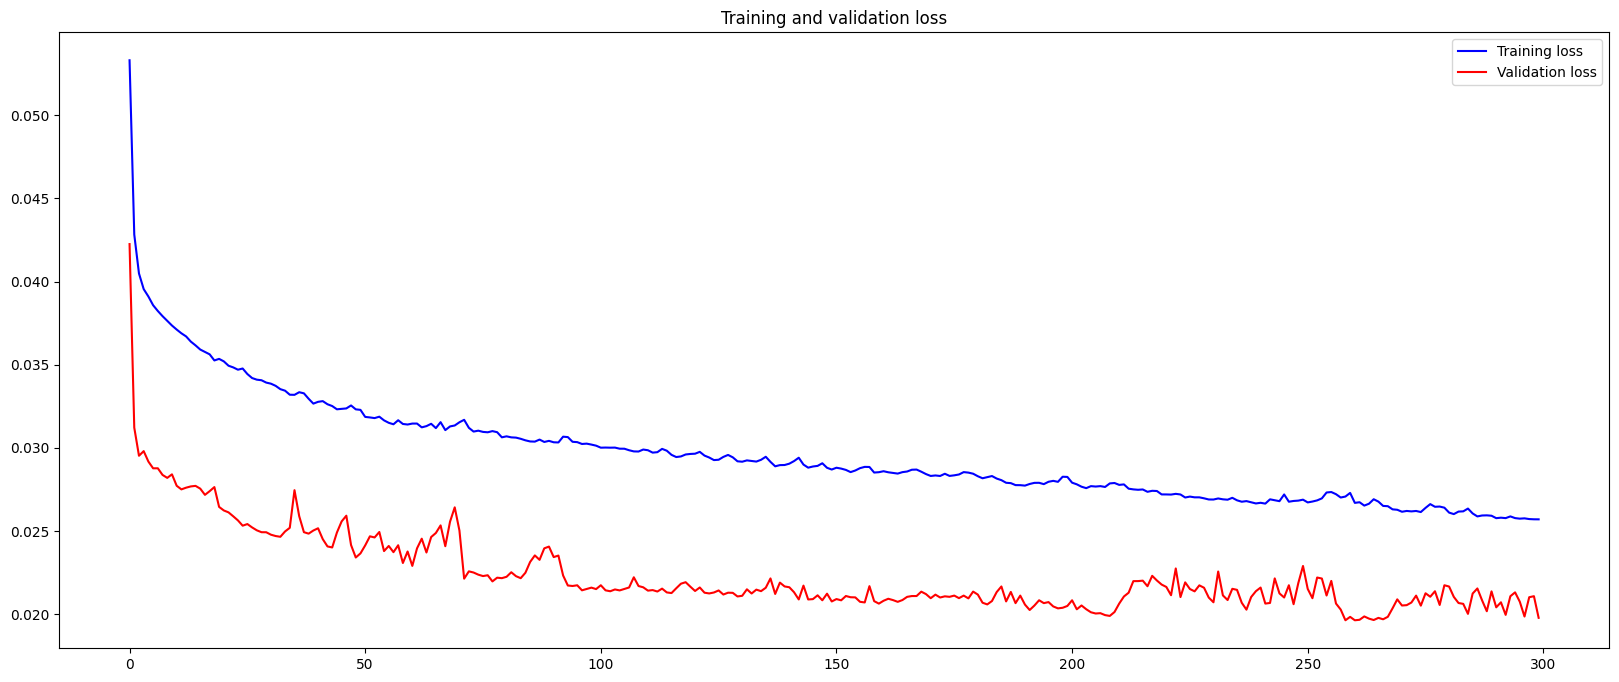

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step  


{'mae': np.float32(0.016229834),
 'mse': np.float32(0.0005000203),
 'r2': 0.5531795024871826}

#### Plot predictions

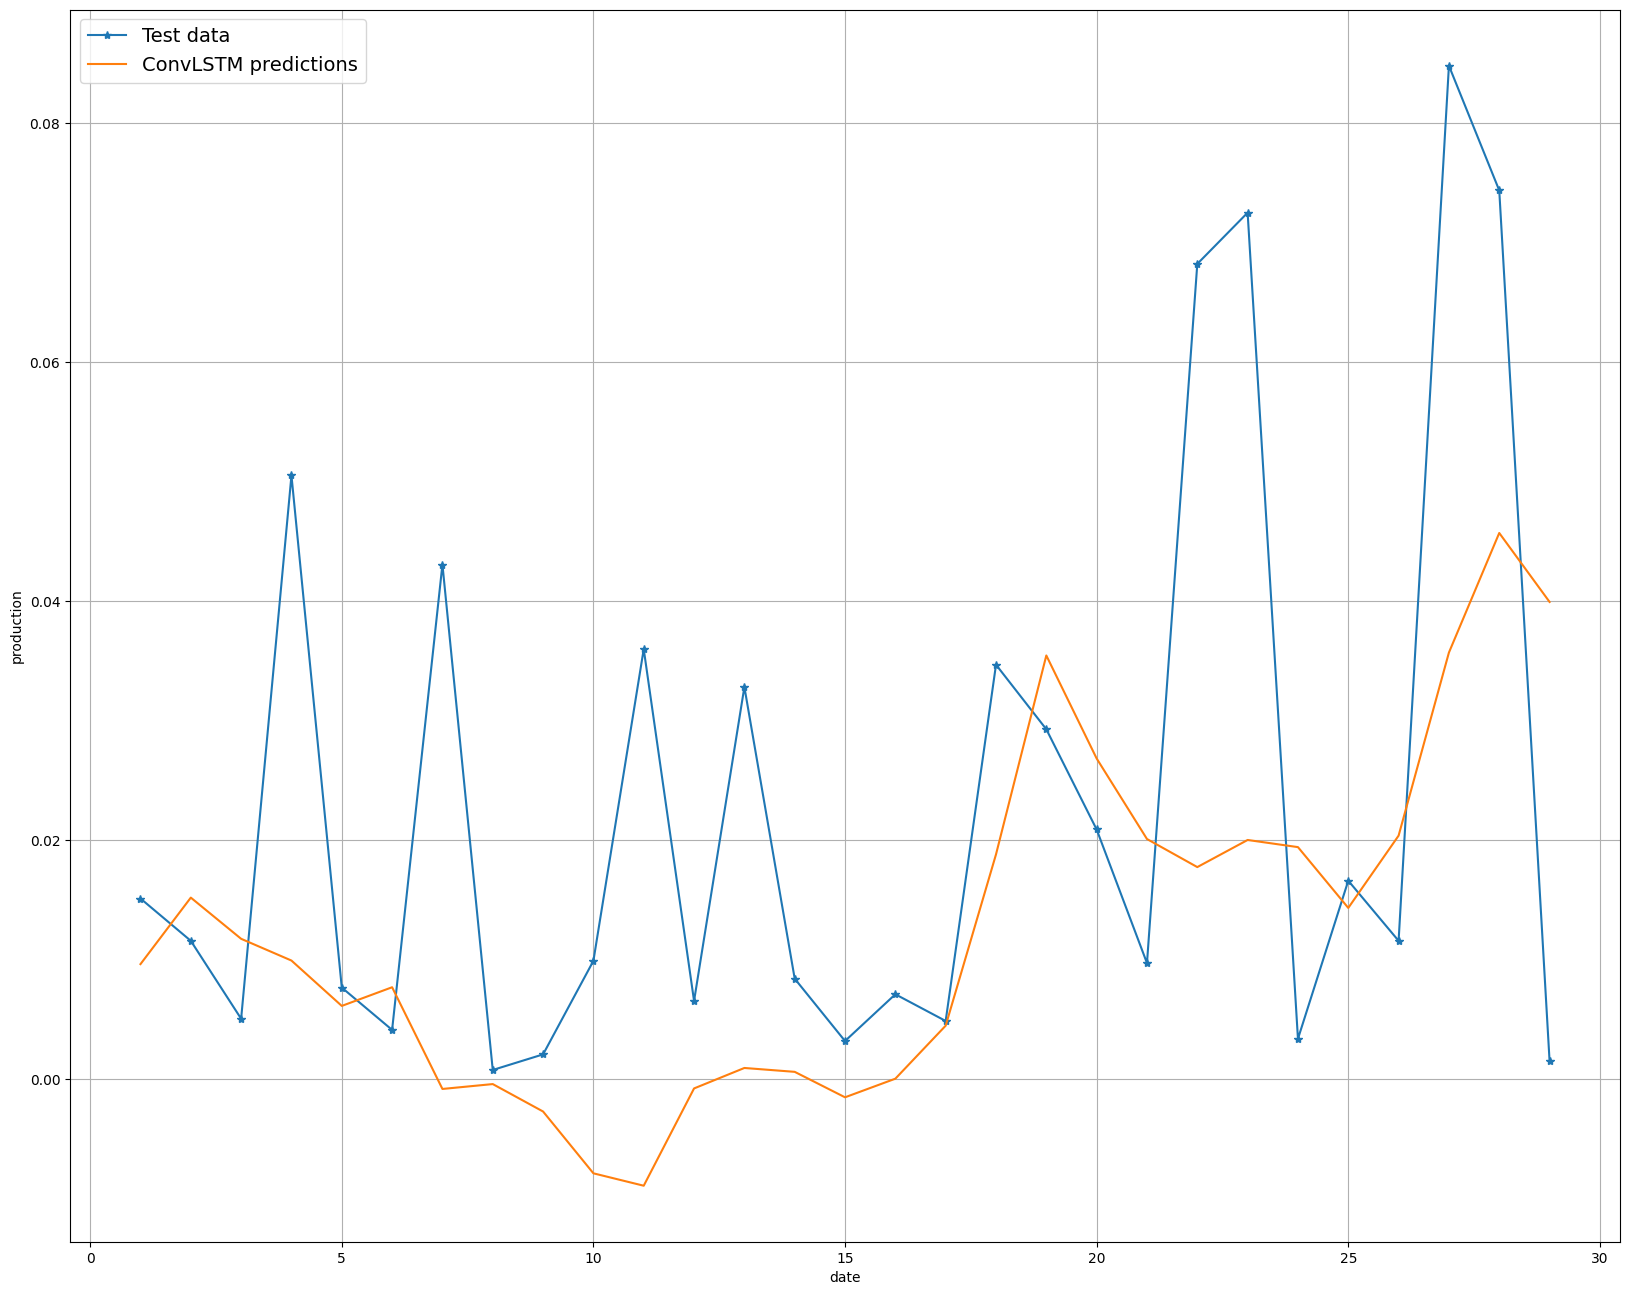

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [24]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Définition de la fonction objective pour Optuna
def objective(trial):
    # Suggestions d'hyperparamètres
    filters1 = trial.suggest_categorical('filters1', [16, 32, 64, 96, 128])
    filters2 = trial.suggest_categorical('filters2', [16, 32, 64, 96, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [1])  # Fixé à 1
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 96, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
    
    # Construction du modèle avec ces hyperparamètres
    model = Sequential([
        ConvLSTM1D(filters=filters1, kernel_size=(kernel_size,), activation='tanh',
                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        ConvLSTM1D(filters=filters2, kernel_size=(kernel_size,), activation=activation, return_sequences=False),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')
    
    # Entraînement rapide pour l'optimisation
    model.fit(x_train_conv_lstm, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val_conv_lstm, y_val))
    score = model.evaluate(x_val_conv_lstm, y_val, verbose=0)
    return score

# Lancer l'étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Affichage des meilleurs hyperparamètres trouvés
print("Best hyperparameters:", study.best_params)


[I 2025-04-02 15:35:40,951] A new study created in memory with name: no-name-2f8d5fef-5161-40a0-b46c-a7fa13a58dfc
C:\Users\yhoci\AppData\Local\Temp\ipykernel_35316\2571516682.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-02 15:37:09,590] Trial 0 finished with value: 0.022746888920664787 and parameters: {'filters1': 128, 'filters2': 128, 'kernel_size': 1, 'activation': 'relu', 'dense_units': 96, 'learning_rate': 0.0017110735691686885}. Best is trial 0 with va

Best hyperparameters: {'filters1': 128, 'filters2': 64, 'kernel_size': 1, 'activation': 'tanh', 'dense_units': 64, 'learning_rate': 0.0013265066726892468}
